In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns
import numpy as np
from joblib import dump, load

In [3]:
data_folder = "../data"
model_folder = "../models"
train_file = "train_data.csv"
train_data = pd.read_csv(os.path.join(data_folder, train_file))
np.random.seed(2308723)
random_state = 84738

In [4]:
train_data.head()

,mu_ip,sigma_ip,kurtosis_ip,skewness_ip,mu_dmsnr,sigma_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
0,119.070312,54.464321,0.082501,-0.167191,0.617893,9.939801,19.553781,429.015329,0
1,89.687500,43.502110,0.437278,0.466080,5.973244,31.325766,5.831691,34.735606,0
2,108.765625,43.813612,0.251548,0.227560,2.653846,20.597689,8.887964,84.319531,0
3,76.492188,38.122745,0.750549,2.556619,3.250000,22.389197,7.711294,62.916367,0
4,97.007812,49.176579,0.574170,0.269369,104.935619,99.374734,0.053575,-1.779702,0


In [5]:
X_train = train_data.values[:, :-1]
y_train = train_data.values[:, -1]

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(X_train.shape)
X_train_pca = pca.fit_transform(X_train)

(14318, 8)


# SVM Classifiers (Linear & RBF)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

We'll compare linear and RBF SVM classifiers. Data didn't look linearly separable in data exploration so we expect RBF kernel to be better.

In [15]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings("ignore")

svc = SVC(random_state=random_state, max_iter=10000)
grid_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': ["balanced", None], 
              'kernel': ['linear', 'rbf']}
svc = GridSearchCV(svc, grid_params, scoring=['f1', 'accuracy'], cv=5, refit='f1')
svc.fit(X_train_scaled, y_train);

In [16]:
def dict_to_str(d):
    s = ""
    for key, item in d.items():
        s += f'{key}: {str(item)}; '
    return s

def get_cv_df(cv_clf):
    cv_res_df = pd.DataFrame()
    cv_res_df['params'] = list(map(dict_to_str, cv_clf.cv_results_['params']))
    cv_res_df['mean_test_f1'] = cv_clf.cv_results_['mean_test_f1']
    cv_res_df['mean_test_accuracy'] = cv_clf.cv_results_['mean_test_accuracy']
    return cv_res_df

In [17]:
cv_res_df = get_cv_df(svc)

In [18]:
cv_res_df.sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False).head(20)

,params,mean_test_f1,mean_test_accuracy
19,C: 10; class_weight: None; kernel: rbf;,0.886150,0.980304
23,C: 100; class_weight: None; kernel: rbf;,0.880916,0.979327
14,C: 1; class_weight: None; kernel: linear;,0.878790,0.979257
18,C: 10; class_weight: None; kernel: linear;,0.878389,0.979047
15,C: 1; class_weight: None; kernel: rbf;,0.873071,0.978279
10,C: 0.1; class_weight: None; kernel: linear;,0.872669,0.978419
13,C: 1; class_weight: balanced; kernel: rbf;,0.870527,0.975276
21,C: 100; class_weight: balanced; kernel: rbf;,0.869417,0.975346
8,C: 0.1; class_weight: balanced; kernel: linear;,0.868366,0.974997
27,C: 1000; class_weight: None; kernel: rbf;,0.867360,0.976673


Turns out RBF is better than linear kernel, but only very very slightly. Weighted classes seems to be consistently worse than no weights. Extreme values for C are worse than C being around 1 or 10

In [19]:
svc_clf = svc.best_estimator_
dump(svc_clf, os.path.join(model_folder, "svc.joblib"))

['../models\\svc.joblib']

In [20]:
svc.best_score_

0.8861500309538975

In [21]:
svm_predictions = svc_clf.predict(X_train_scaled)
support_vectors = svc_clf.support_vectors_
support_vectors_pca = pca.transform(support_vectors)

In [22]:
def results(predictions, targets):
    def compare(x, y):
        if x == 1 and y == 1:
            return "true positive"
        elif x == 0 and y == 0:
            return "true negative"
        elif x == 1 and y == 0:
            return "false positive"
        else: 
            return "false negative"
    func = np.vectorize(compare)
    return func(predictions, targets)

In [25]:
def plot_results_2d(predictions, support_vectors=None):
    results_df = pd.DataFrame()
    results_df["comp_1"] = X_train_pca[:, 0]
    results_df["comp_2"] = X_train_pca[:, 1]
    results_df["result"] = results(predictions, y_train)

    colors = ["bright blue", "grass green", "orange", "purple"]
    my_palette = list(map(lambda x: sns.xkcd_rgb[x], colors))
    sizes = [30, 30, 300, 300]
    
    n_unique_results = results_df["result"].nunique()
    if n_unique_results  < len(my_palette):
        my_palette = my_palette[:n_unique_results]
    if n_unique_results < len(sizes):
        sizes = sizes[:n_unique_results]
    
    if support_vectors is not None:
        my_palette.append(sns.xkcd_rgb["dark grey"])
        sizes.append(300)
        
        sv_df = pd.DataFrame()
        sv_df["comp_1"] = support_vectors[:, 0]
        sv_df["comp_2"] = support_vectors[:, 1]
        sv_df["result"] = "support vector"
        results_df = pd.concat([results_df, sv_df])
        
    print(results_df["result"].value_counts())
    
    sns.set(rc={'figure.figsize':(10, 8)})
    sns.scatterplot(x="comp_1", y="comp_2", hue="result", size="result",
                    sizes=sizes, palette=my_palette, data=results_df)
    plt.xlim(-200, 400)

true negative     12947
true positive      1109
support vector      753
false negative      202
false positive       60
Name: result, dtype: int64


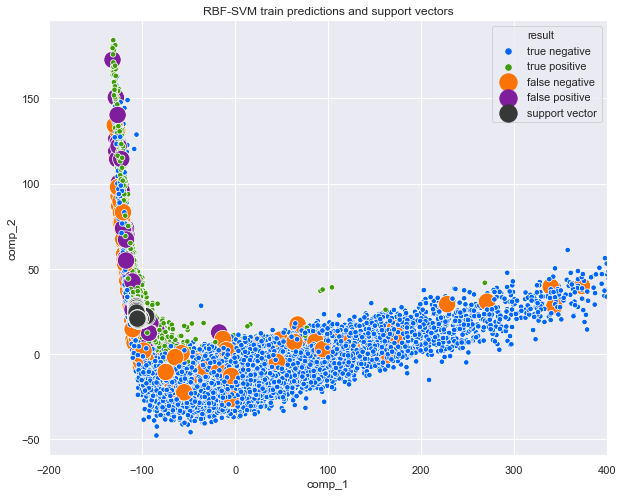

In [26]:
plot_results_2d(svm_predictions, support_vectors_pca)
plt.title("RBF-SVM train predictions and support vectors")
plt.savefig("predictions/rbf_svm_predictions.png")

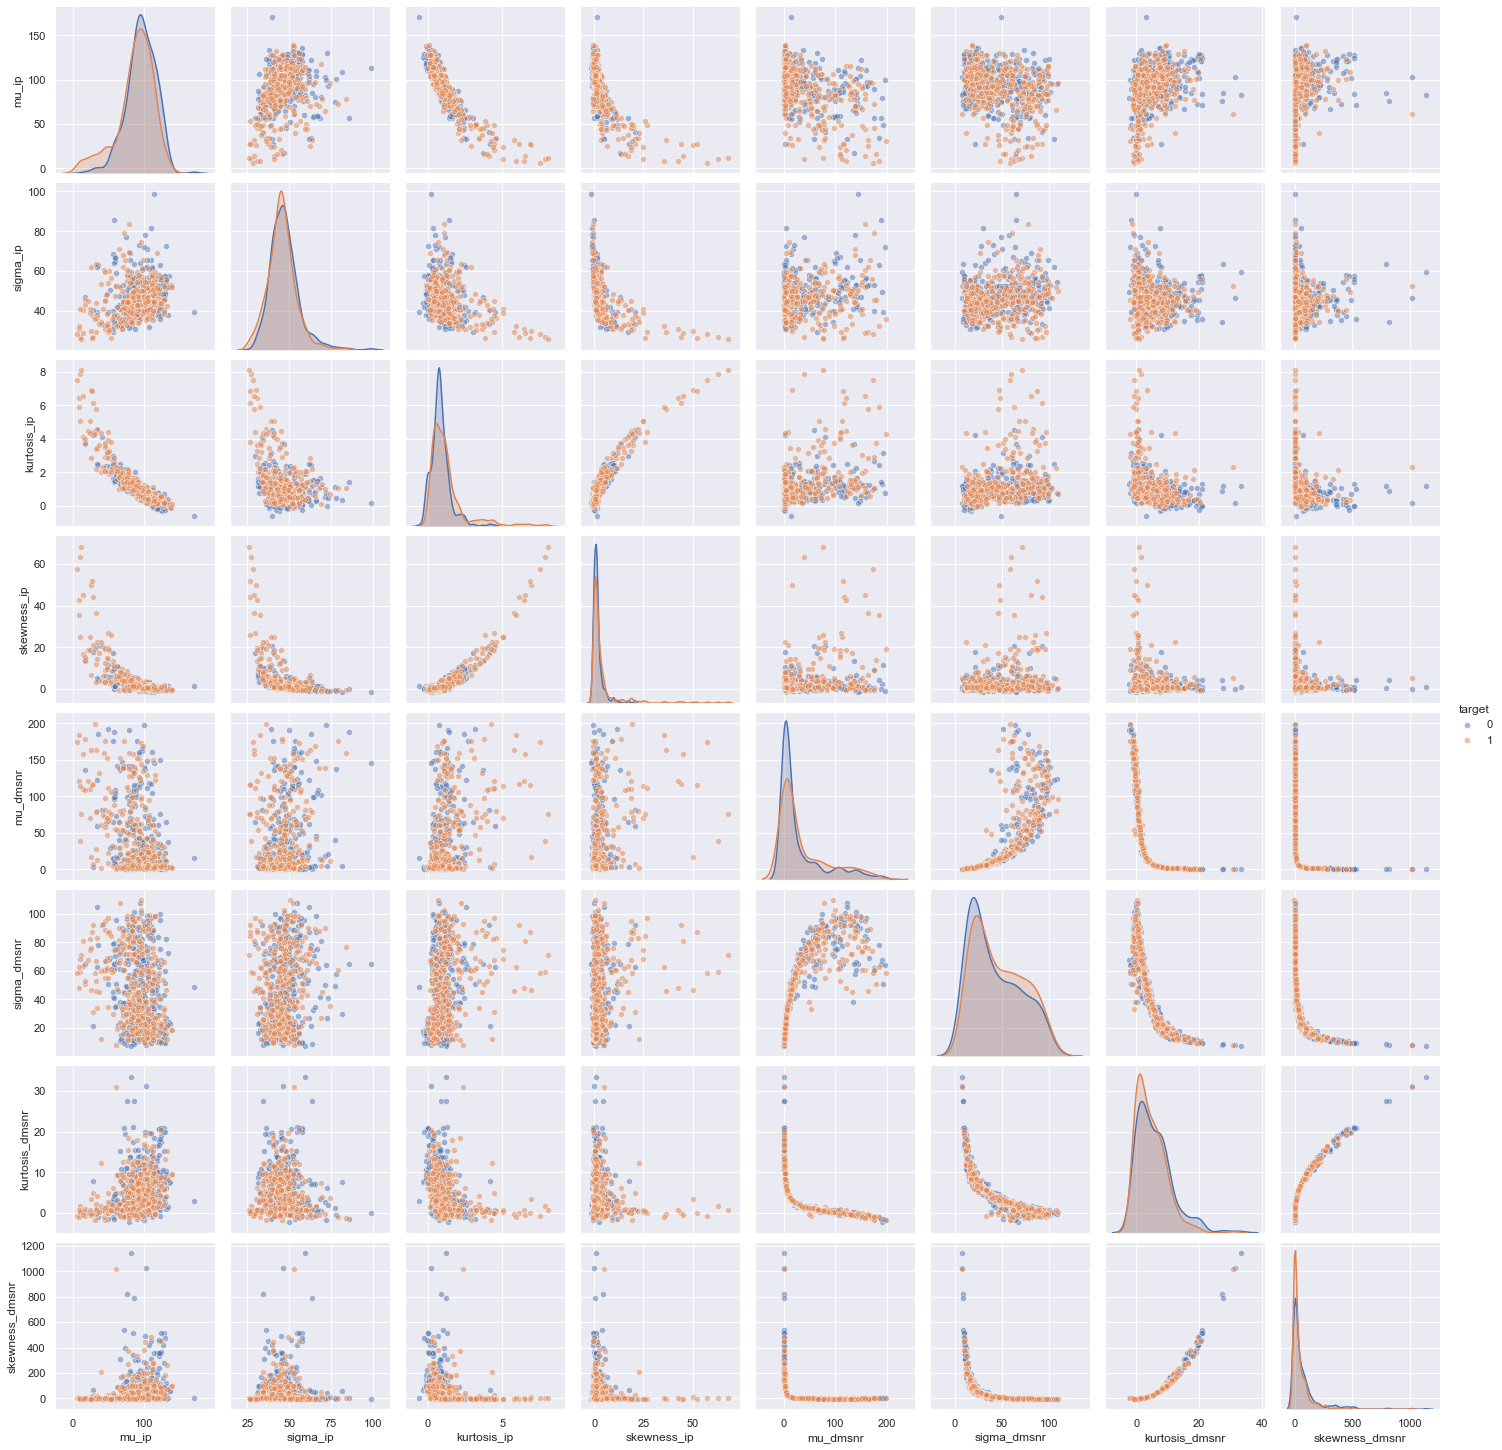

In [97]:
support_vectors = train_data.iloc[svc_clf.support_, :]
sns.pairplot(support_vectors, hue="target", plot_kws={'alpha':0.5});

In [98]:
support_vectors["target"].value_counts()

0    391
1    362
Name: target, dtype: int64

In [100]:
sum(svm_predictions)

1169.0

In [101]:
sum(y_train)

1311.0

# Logistic Regression Classifier

In [102]:
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("default")

lreg = LogisticRegression(random_state=random_state, solver="saga")
params = {"penalty": ["l2", "elasticnet"], 
         'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'class_weight': ["balanced", None],
          'l1_ratio': [0.1, 0.3, 0.5, 0.8, 1]}
lreg_cv = GridSearchCV(lreg, params, cv=5, scoring=['f1', 'accuracy'], n_jobs=-1, refit="f1", verbose=5)
lreg_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   35.0s finished
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=84738, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'penalty': ['l2', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['f1', 

In [104]:
lreg_cv.best_score_

0.8791640563340133

In [105]:
lreg_cv_df = get_cv_df(lreg_cv)
pd.set_option('max_colwidth', 400)
lreg_cv_df.sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False)

,params,mean_test_f1,mean_test_accuracy
90,C: 10; class_weight: None; l1_ratio: 0.1; penalty: l2;,0.879164,0.979187
91,C: 10; class_weight: None; l1_ratio: 0.1; penalty: elasticnet;,0.879164,0.979187
92,C: 10; class_weight: None; l1_ratio: 0.3; penalty: l2;,0.879164,0.979187
93,C: 10; class_weight: None; l1_ratio: 0.3; penalty: elasticnet;,0.879164,0.979187
94,C: 10; class_weight: None; l1_ratio: 0.5; penalty: l2;,0.879164,0.979187
...,...,...,...
11,C: 0.001; class_weight: None; l1_ratio: 0.1; penalty: elasticnet;,0.713141,0.958793
13,C: 0.001; class_weight: None; l1_ratio: 0.3; penalty: elasticnet;,0.688964,0.956209
15,C: 0.001; class_weight: None; l1_ratio: 0.5; penalty: elasticnet;,0.653230,0.952577
17,C: 0.001; class_weight: None; l1_ratio: 0.8; penalty: elasticnet;,0.600945,0.947618


In [106]:
lreg_cv_df['mean_test_f1'].mean()

0.8413607715636805

In [107]:
svc.best_score_

0.8861500309538975

In [108]:
dump(lreg_cv.best_estimator_, os.path.join(model_folder, "log_reg.joblib"))

['../models\\log_reg.joblib']

Logistic regression is just a tiny bit less effective than RBF-SVM.

true negative     12937
true positive      1085
false negative      226
false positive       70
Name: result, dtype: int64


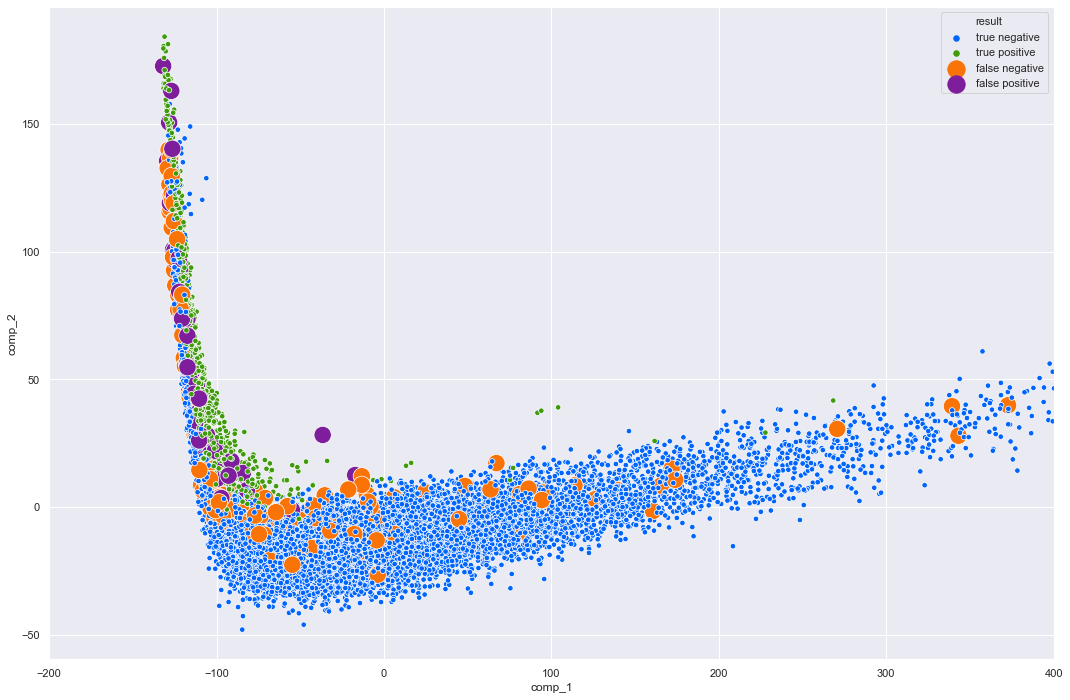

In [109]:
lreg_predictions = lreg_cv.best_estimator_.predict(X_train_scaled)
plot_results_2d(lreg_predictions)
plt.savefig("predictions/log_reg_predictions.png")

We can note that the performance diff between the RBF SVM and the Logistic Regression is not negligible on the training set as SVM has 10% less false results approx relatively to the Logistic Regression.

SVM : 
false negative      202
false positive       60

Log reg :
false negative      226
false positive       70

# Random Forest Classifier

We will tune the forest classifier with a ParameterGrid without using cross-validation, since out-of-bag error does the job of evaluation generalization error without needing to evaluate the model on a validation set.

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, random_state=random_state)

np.random.seed(3049340)
params = {"max_depth": [5, 10, 30, 50, 100], 
         "class_weight": ["balanced", None], 
         "max_features": ["auto", "sqrt", "log2"]}
pgrid = ParameterGrid(params)

best_score = 0
best_param = None

for param in pgrid:
    rf.set_params(**param)
    rf.fit(X_train, y_train)
    print(f'training param {param} has oob score {rf.oob_score_}')
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_param = param

C:\Users\ribau\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


training param {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'auto'} has oob score 0.9712948735856963
training param {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt'} has oob score 0.9712948735856963
training param {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2'} has oob score 0.972132979466406
training param {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'auto'} has oob score 0.9785584578851795
training param {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt'} has oob score 0.9785584578851795
training param {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2'} has oob score 0.9780695627880989
training param {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'auto'} has oob score 0.9793965637658891
training param {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt'} has oob score 0.9793965637658891
training param {'class_weight': 'balanced', 'max_depth': 30,

In [111]:
print(f'{best_param} is the best param with an oob score of {best_score}')

{'class_weight': None, 'max_depth': 10, 'max_features': 'log2'} is the best param with an oob score of 0.9803743539600502


In [112]:
rf_big = RandomForestClassifier(n_estimators=10000, n_jobs=-1, oob_score=True, random_state=random_state, verbose=1)
rf_big.set_params(**best_param)
rf_big.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=True, random_state=84738, verbose=1,
                       warm_start=False)

In [113]:
rf_big.oob_score_

0.9803743539600502

In [114]:
tree_depths = []
training_errors = []
oob_errors = []

for tree_depth in [1, 3, 5, 10, 15, 20, 30, 50, 75, 100]:
    print(f'Tree depth = {tree_depth}')
    rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=random_state, n_jobs=-1)
    rf.set_params(**best_param)
    rf.set_params(**{'max_depth': tree_depth})
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    training_error = np.mean(abs(predictions - y_train))
    oob_error = 1 - rf.oob_score_
    tree_depths.append(tree_depth)
    training_errors.append(training_error)
    oob_errors.append(oob_error)

Tree depth = 1
Tree depth = 3
Tree depth = 5
Tree depth = 10
Tree depth = 15
Tree depth = 20
Tree depth = 30
Tree depth = 50
Tree depth = 75
Tree depth = 100


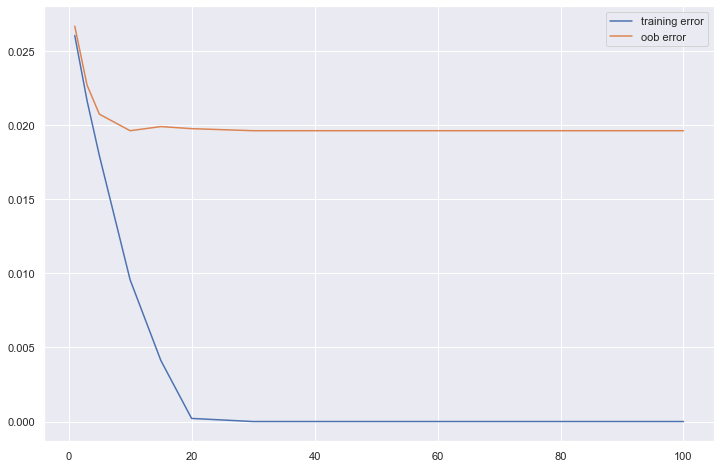

In [115]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(tree_depths, training_errors, label="training error")
ax.plot(tree_depths, oob_errors, label="oob error")
ax.legend()

Double checking generalization error by cross validating the best model.

In [10]:
from sklearn.model_selection import cross_validate

rf_best = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=random_state, verbose=1)
rf_best.set_params(**best_param)
cv_scores = cross_validate(rf_best, X_train, y_train, scoring = ['f1', 'accuracy'], cv=5, n_jobs=-1, verbose=1)

NameError: name 'RandomForestClassifier' is not defined

In [117]:
cv_scores

{'fit_time': array([23.8234756 , 23.68247986, 23.63849473, 23.70051503, 20.93998909]),
 'score_time': array([0.33500004, 0.35800171, 0.34398437, 0.33799958, 0.30995345]),
 'test_f1': array([0.8950495 , 0.86938776, 0.89112903, 0.89587426, 0.87649402]),
 'test_accuracy': array([0.98149441, 0.97765363, 0.98114525, 0.98148795, 0.97834439])}

In [118]:
(cv_scores['test_f1'].mean(), cv_scores['test_f1'].std())

(0.885586915895256, 0.010688111679795902)

In [119]:
(cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std())

(0.9800251279569621, 0.0016734507368117949)

In [120]:
rf_best.fit(X_train, y_train)
dump(rf_best, os.path.join(model_folder, "rf_best.joblib"))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   27.6s finished


['../models\\rf_best.joblib']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.7s finished


true negative     12995
true positive      1186
false negative      125
false positive       12
Name: result, dtype: int64


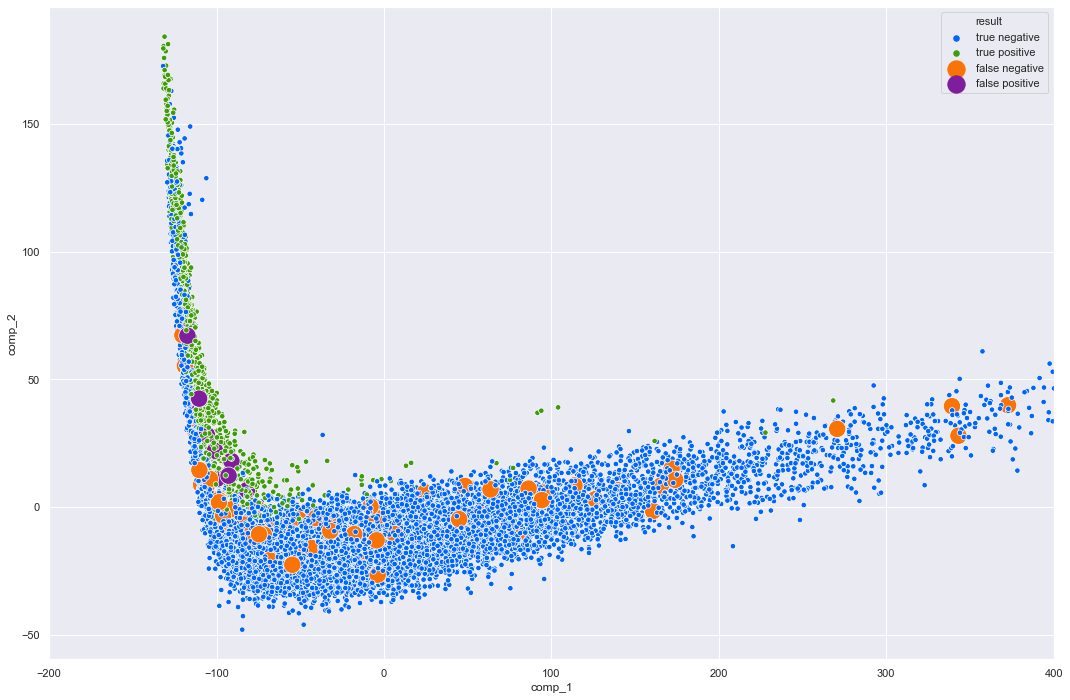

In [121]:
predictions_rf = rf_best.predict(X_train)
plot_results_2d(predictions_rf)
plt.savefig("predictions/rf_predictions.png")

This Random Forest is doing really well on the training data as the number of false positive and false negative have been reduced by half. However it is overfitting a bit as seen previously. Estimated generalization error is still a bit better with this model than with RBF-SVM and Logistic Regression. Increasing the nb of estimators to 10000 didn't improve the test score further. 

In [122]:
list(zip(train_data.columns[:-1], rf_best.feature_importances_))

[('mu_ip', 0.16228260381820764),
 ('sigma_ip', 0.031087882127711745),
 ('kurtosis_ip', 0.4247712782959571),
 ('skewness_ip', 0.2379491871551796),
 ('mu_dmsnr', 0.053476274630177054),
 ('sigma_dmsnr', 0.04939173179399598),
 ('kurtosis_dmsnr', 0.02266822424008832),
 ('skewness_dmsnr', 0.018372817938682534)]

Looks like the most important feature are the integrated profile characteristics, mainly kurtosis and skewness. Dispersion measure signal-to-noise-ratio features have a low to moderate importance.

# Ada Boost Classifier

In [123]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=random_state), n_estimators=100, random_state=random_state)
grid_params = {'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'base_estimator__max_features': ["auto", "log2", None],
              'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001]}

adab_grid = GridSearchCV(adab, grid_params, n_jobs=-1, verbose=5, scoring=["f1", "accuracy"], refit="f1")
adab_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  9.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1

In [124]:
adab_grid.best_score_
best_params = adab_grid.best_params_

In [126]:
adab_grid_df = get_cv_df(adab_grid)
pd.set_option('max_colwidth', 400)
pd.set_option("display.max_rows", 100)
adab_grid_df.sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False).head(10)

,params,mean_test_f1,mean_test_accuracy
66,base_estimator__max_depth: 5; base_estimator__max_features: log2; learning_rate: 0.1;,0.887743,0.980514
145,base_estimator__max_depth: 10; base_estimator__max_features: None; learning_rate: 1;,0.887259,0.980305
125,base_estimator__max_depth: 9; base_estimator__max_features: log2; learning_rate: 1;,0.886852,0.980165
100,base_estimator__max_depth: 7; base_estimator__max_features: None; learning_rate: 1;,0.886428,0.980095
135,base_estimator__max_depth: 10; base_estimator__max_features: auto; learning_rate: 1;,0.886150,0.980165
107,base_estimator__max_depth: 8; base_estimator__max_features: auto; learning_rate: 0.01;,0.886000,0.980374
120,base_estimator__max_depth: 9; base_estimator__max_features: auto; learning_rate: 1;,0.885829,0.980025
110,base_estimator__max_depth: 8; base_estimator__max_features: log2; learning_rate: 1;,0.885606,0.980025
111,base_estimator__max_depth: 8; base_estimator__max_features: log2; learning_rate: 0.1;,0.884755,0.979955
141,base_estimator__max_depth: 10; base_estimator__max_features: log2; learning_rate: 0.1;,0.884230,0.979886


In [130]:
adab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=random_state, 
                                                                max_depth=best_params['base_estimator__max_depth'],
                                                                max_features=best_params['base_estimator__max_features']),
                          n_estimators=1000, random_state=random_state)
grid_params = {'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
adab_grid = GridSearchCV(adab, grid_params, n_jobs=-1, verbose=5, scoring=["f1", "accuracy"], refit="f1")
adab_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=5,
                                                                                max_features='log2',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,

In [131]:
adab_grid_df = get_cv_df(adab_grid)
pd.set_option('max_colwidth', 400)
pd.set_option("display.max_rows", 100)
adab_grid_df.sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False).head(10)

,params,mean_test_f1,mean_test_accuracy
7,learning_rate: 0.5;,0.887283,0.980305
4,learning_rate: 0.01;,0.885352,0.980025
8,learning_rate: 1;,0.883945,0.979676
2,learning_rate: 0.001;,0.882427,0.979746
5,learning_rate: 0.05;,0.882185,0.979536
6,learning_rate: 0.1;,0.881300,0.979327
1,learning_rate: 0.0005;,0.880638,0.979536
3,learning_rate: 0.005;,0.878527,0.978908
0,learning_rate: 0.0001;,0.874176,0.978419


In [132]:
adab_clf = adab_grid.best_estimator_
dump(adab_clf, os.path.join(model_folder, "adab_clf.joblib"))

['../models\\adab_clf.joblib']

true negative    13007
true positive     1311
Name: result, dtype: int64


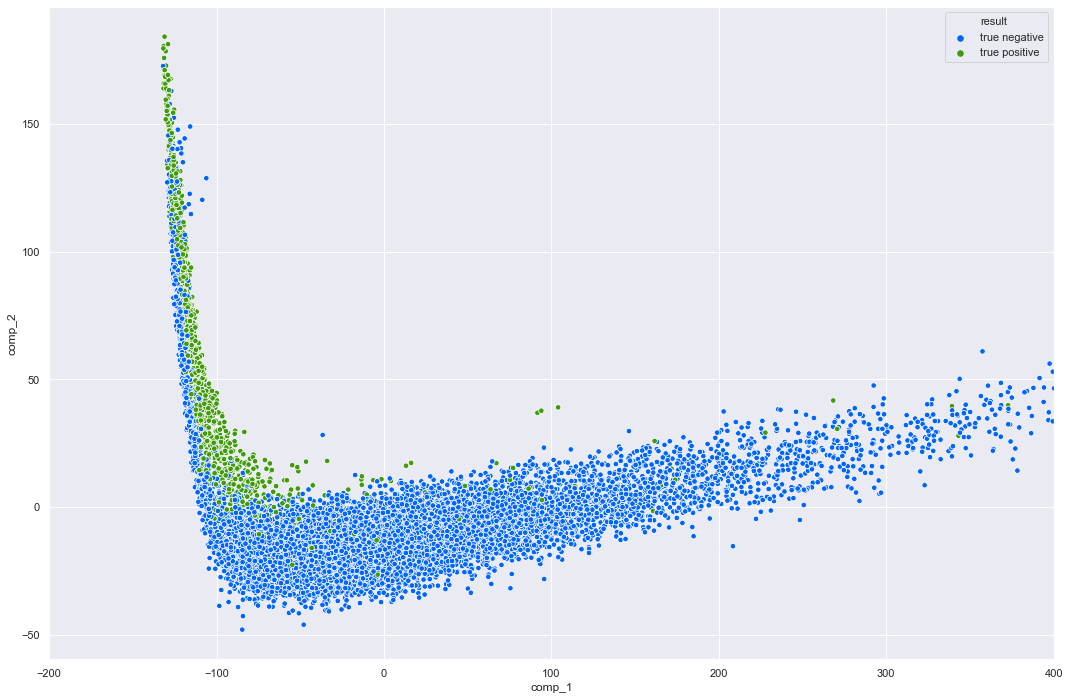

In [133]:
predictions = adab_clf.predict(X_train_scaled)
plot_results_2d(predictions)
plt.savefig('predictions/adab_predictions.png')

Adaboost always fits the training set perfectly given enough estimators.

# XGBoost Classifier

In [135]:
import xgboost as xgb

We first train a model with all the default xgboost parameter values to see the initial accuracy.

In [136]:
len(X_train_scaled)

14318

In [137]:
train_size = int(len(X_train_scaled)*0.8)
val_size = len(X_train_scaled) - train_size
val_labels = y_train[train_size:]
dtrain = xgb.DMatrix(X_train_scaled[:train_size, :], label=y_train[:train_size])
dval = xgb.DMatrix(X_train_scaled[train_size:, :], label=val_labels)

In [138]:
params = {'objective': 'binary:hinge'}
bst = xgb.train(params, dtrain)

In [139]:
preds = bst.predict(dval)

In [140]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_val = f1_score(val_labels, preds)
acc_val = accuracy_score(val_labels, preds)
precision = precision_score(val_labels, preds)
recall = recall_score(val_labels, preds)
print(f'f1 score is {f1_val} and accuracy is {acc_val} on validation data')
print(f'precision is {precision} and recall is {recall} on validation data')

f1 score is 0.8671875 and accuracy is 0.9762569832402235 on validation data
precision is 0.9061224489795918 and recall is 0.8314606741573034 on validation data


f1 score value is really not great. we had an f1_score of 0.98 with adaboost classifier.
about 10% of positives are false positives, and about 17% of positive labels are missclassified as negative.
we will now try to tune the model.

In [141]:
def f1_eval(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a
    # colon (:) or a space since preds are margin(before logistic
    # transformation, cutoff at 0)
    return 'f1_eval', 1 - f1_score(labels, preds)

In [267]:
def f1_eval_logits(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a
    # colon (:) or a space since preds are margin(before logistic
    # transformation, cutoff at 0)
    def make_prediction(proba):
        if proba >= 0.5:
            return 1
        else:
            return 0
    make_prediction_v = np.vectorize(make_prediction)
    new_preds = make_prediction_v(preds)
    return 'f1_eval', 1 - f1_score(labels, new_preds)

In [272]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

sum_wpos = sum(y_train)
sum_wneg = len(y_train) - sum_wpos

xgb_clf = xgb.XGBClassifier()
eta = 0.1
params_dict = {
    'eta': eta,
    'max_depth': 5, 
    'gamma': 0, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic'
}


In [274]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)

eval_results = {}
cvresult = xgb.cv(params_dict, dtrain, num_boost_round=2000, 
                  nfold=5, feval=f1_eval_logits, early_stopping_rounds=None)

In [275]:
cvresult

,train-error-mean,train-error-std,test-error-mean,test-error-std,train-f1_eval-mean,train-f1_eval-std,test-f1_eval-mean,test-f1_eval-std
0,0.018438,0.000642,0.020883,0.002308,0.105612,0.002700,0.119291,0.011347
1,0.017810,0.001389,0.020673,0.003047,0.102628,0.007583,0.119704,0.018477
2,0.017810,0.001597,0.020813,0.002019,0.102258,0.008793,0.120237,0.013386
3,0.017530,0.001300,0.019905,0.002152,0.100662,0.006768,0.115067,0.014439
4,0.017233,0.000794,0.020184,0.002770,0.098922,0.003759,0.116792,0.016203
...,...,...,...,...,...,...,...,...
1995,0.000000,0.000000,0.020673,0.003202,0.000000,0.000000,0.117312,0.014275
1996,0.000000,0.000000,0.020673,0.003202,0.000000,0.000000,0.117312,0.014275
1997,0.000000,0.000000,0.020673,0.003202,0.000000,0.000000,0.117312,0.014275
1998,0.000000,0.000000,0.020603,0.003206,0.000000,0.000000,0.116870,0.014317


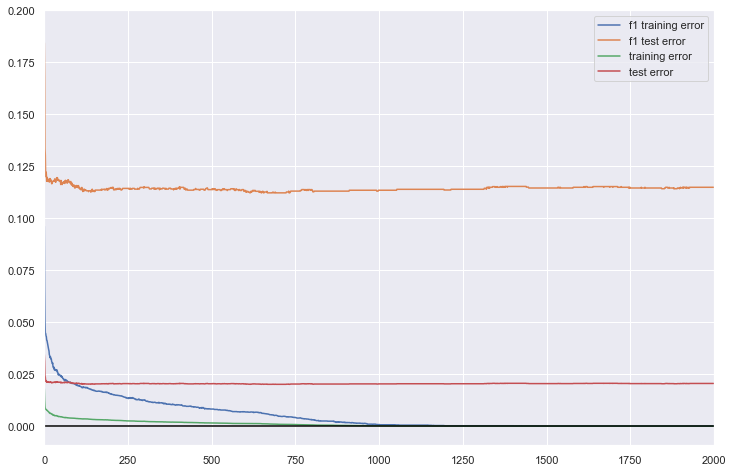

In [325]:
def plot_evals(cvresult, min_y=None, max_y=0.2):
    fig, ax = plt.subplots(figsize=(12, 8))
    x = range(len(cvresult))
    ax.plot(x, cvresult['train-f1_eval-mean'], label="f1 training error")
    ax.plot(x, cvresult['test-f1_eval-mean'], label="f1 test error")
    ax.plot(x, cvresult['train-error-mean'], label="training error")
    ax.plot(x, cvresult['test-error-mean'], label="test error")
    ax.axhline(0, color="black")
    plt.xlim(0, len(x))
    plt.ylim(min_y, max_y)
    plt.legend()
    
plot_evals(cvresult)

In [277]:
n_estimators = np.argmin(cvresult['test-f1_eval-mean'].values)
max_f1 = 1 - min(cvresult['test-f1_eval-mean'])
(n_estimators, f'f1 score is {max_f1}')

(61, 'f1 score is 0.8894152')

In [278]:
xgb.__version__

'1.1.1'

In [279]:
params_dict = {
    'eta': eta,
    'max_depth': 5, 
    'gamma': 0, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'n_estimators': n_estimators,
}

xbg_clf = xgb.XGBClassifier(**params_dict)
xgb_clf.set_params(**params_dict)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, eta=0.1, gamma=0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=61, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=None, verbosity=None)

In [280]:
%%time
params_grid_v2 = {'max_depth': range(1, 15),
               'min_child_weight': range(1, 10)}
bst_cv_2 = GridSearchCV(xgb_clf, param_grid=params_grid_v2, scoring=["f1", "accuracy"], refit="f1", verbose=2)
bst_cv_2.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV] max_depth=1, min_child_weight=1 .................................
[CV] .................. max_depth=1, min_child_weight=1, total=   0.1s
[CV] max_depth=1, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................. max_depth=1, min_child_weight=1, total=   0.1s
[CV] max_depth=1, min_child_weight=1 .................................
[CV] .................. max_depth=1, min_child_weight=1, total=   0.1s
[CV] max_depth=1, min_child_weight=1 .................................
[CV] .................. max_depth=1, min_child_weight=1, total=   0.1s
[CV] max_depth=1, min_child_weight=1 .................................
[CV] .................. max_depth=1, min_child_weight=1, total=   0.1s
[CV] max_depth=1, min_child_weight=2 .................................
[CV] .................. max_depth=1, min_child_weight=2, total=   0.1s
[CV] max_depth=1, min_child_weight=2 .................................
[CV] .................. max_depth=1, min_child_weight=2, total=   0.1s
[CV] max_depth=1, min_child_weight=2 .................................
[CV] .................. max_depth=1, min_child_weight=2, total=   0.1s
[CV] max_depth=1, min_child_weight=2 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed:  3.1min finished


Wall time: 3min 4s


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, eta=0.1, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_e...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=0.8, tree_method=Non

In [281]:
bst_cv_2.best_score_

0.8880638216451932

In [282]:
bst_cv_2.best_params_

{'max_depth': 14, 'min_child_weight': 1}

In [283]:
bst_cv_2.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.100000001,
 'max_delta_step': 0,
 'max_depth': 14,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 61,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eta': 0.1}

In [284]:
get_cv_df(bst_cv_2).sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False)

,params,mean_test_f1,mean_test_accuracy
117,max_depth: 14; min_child_weight: 1;,0.888064,0.980374
27,max_depth: 4; min_child_weight: 1;,0.887837,0.980374
81,max_depth: 10; min_child_weight: 1;,0.886951,0.980235
120,max_depth: 14; min_child_weight: 4;,0.886785,0.980165
38,max_depth: 5; min_child_weight: 3;,0.886664,0.980165
...,...,...,...
15,max_depth: 2; min_child_weight: 7;,0.872153,0.977860
13,max_depth: 2; min_child_weight: 5;,0.871670,0.977790
16,max_depth: 2; min_child_weight: 8;,0.871324,0.977720
14,max_depth: 2; min_child_weight: 6;,0.871317,0.977720


In [285]:
for name, val in bst_cv_2.best_params_.items():
    params_dict[name] = val

In [286]:
params_dict
xbg_clf = xgb.XGBClassifier()
xgb_clf.set_params(**params_dict)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, eta=0.1, gamma=0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=14,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=61, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=None, verbosity=None)

In [287]:
params_grid_v3 = {'gamma': [i/10.0 for i in range(0, 5)]}
bst_cv_3 = GridSearchCV(xgb_clf, param_grid=params_grid_v3, scoring=["f1", "accuracy"], refit="f1", verbose=2)
bst_cv_3.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ gamma=0.0, total=   0.5s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ........................................ gamma=0.0, total=   0.5s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   0.5s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   0.5s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   0.5s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   0.5s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   0.5s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   0.4s
[CV] gamma=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   11.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, eta=0.1, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=14, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
      

In [288]:
get_cv_df(bst_cv_3).sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False)

,params,mean_test_f1,mean_test_accuracy
0,gamma: 0.0;,0.888064,0.980374
3,gamma: 0.3;,0.887317,0.980305
1,gamma: 0.1;,0.886093,0.980025
2,gamma: 0.2;,0.885743,0.980025
4,gamma: 0.4;,0.884965,0.979886


In [289]:
params_dict['gamma'] = bst_cv_3.best_params_['gamma']
params_dict

{'eta': 0.1,
 'max_depth': 14,
 'gamma': 0.0,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'objective': 'binary:logistic',
 'n_estimators': 61,
 'min_child_weight': 1}

In [290]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
params_dict_cv = params_dict
params_dict_cv.pop('n_estimators', None)
cvresult = xgb.cv(params_dict, dtrain, num_boost_round=2000, 
                  nfold=5, feval=f1_eval_logits, early_stopping_rounds=None)

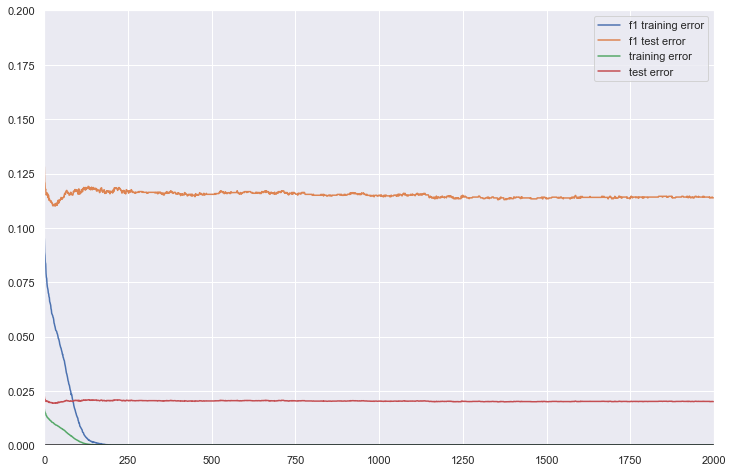

In [291]:
plot_evals(cvresult)

In [292]:
n_estimators = np.argmin(cvresult['test-f1_eval-mean'].values)
max_f1 = 1 - min(cvresult['test-f1_eval-mean'])
(n_estimators, f'f1 score is {max_f1}')

(33, 'f1 score is 0.8899676')

In [293]:
params_dict["n_estimators"] = n_estimators

In [301]:
xbg_clf = xgb.XGBClassifier()
xgb_clf.set_params(**params_dict)
params_grid_v4 = {'scale_pos_weight': range(0, 10)}
bst_cv_4 = GridSearchCV(xgb_clf, param_grid=params_grid_v4, scoring=["f1", "accuracy"], refit="f1", verbose=1)
bst_cv_4.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, eta=0.1, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=14, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_e...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
      

In [302]:
get_cv_df(bst_cv_4).sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False)

,params,mean_test_f1,mean_test_accuracy
5,scale_pos_weight: 5;,0.889852,0.980235
3,scale_pos_weight: 3;,0.886531,0.979746
4,scale_pos_weight: 4;,0.886120,0.979606
7,scale_pos_weight: 7;,0.885379,0.979327
8,scale_pos_weight: 8;,0.885166,0.979257
2,scale_pos_weight: 2;,0.884870,0.979606
9,scale_pos_weight: 9;,0.884458,0.979047
6,scale_pos_weight: 6;,0.884225,0.979117
1,scale_pos_weight: 1;,0.883796,0.979676
0,scale_pos_weight: 0;,0.000000,0.908437


In [303]:
params_dict['scale_pos_weight'] = bst_cv_4.best_params_['scale_pos_weight']
params_dict

{'eta': 0.1,
 'max_depth': 14,
 'gamma': 0.0,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'objective': 'binary:logistic',
 'min_child_weight': 1,
 'n_estimators': 33,
 'scale_pos_weight': 5}

In [309]:
xbg_clf = xgb.XGBClassifier()
xgb_clf.set_params(**params_dict)
params_grid_v5 = {'subsample': np.linspace(0.6, 1, 10),
                  'colsample_bytree': np.linspace(0.6, 1, 10)}
bst_cv_5 = GridSearchCV(xgb_clf, param_grid=params_grid_v5, scoring=["f1", "accuracy"], refit="f1", verbose=1)
bst_cv_5.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, eta=0.1, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=14, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_e...
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': array([0.6       , 0.64444444, 0.68888889, 0.73333333, 0.77777778,
       0.82222222, 0.86666667, 0.91111111, 0.95555556, 1.        ]),
                         'subsample': array([0.6       , 

In [310]:
get_cv_df(bst_cv_5).sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False)

,params,mean_test_f1,mean_test_accuracy
41,colsample_bytree: 0.7777777777777778; subsample: 0.6444444444444444;,0.888399,0.979955
51,colsample_bytree: 0.8222222222222222; subsample: 0.6444444444444444;,0.888399,0.979955
61,colsample_bytree: 0.8666666666666667; subsample: 0.6444444444444444;,0.888399,0.979955
13,colsample_bytree: 0.6444444444444444; subsample: 0.7333333333333333;,0.888360,0.980025
23,colsample_bytree: 0.6888888888888889; subsample: 0.7333333333333333;,0.888360,0.980025
33,colsample_bytree: 0.7333333333333333; subsample: 0.7333333333333333;,0.888360,0.980025
73,colsample_bytree: 0.9111111111111111; subsample: 0.7333333333333333;,0.888177,0.979746
83,colsample_bytree: 0.9555555555555555; subsample: 0.7333333333333333;,0.888177,0.979746
91,colsample_bytree: 1.0; subsample: 0.6444444444444444;,0.888124,0.979816
14,colsample_bytree: 0.6444444444444444; subsample: 0.7777777777777778;,0.888049,0.980025


In [312]:
for key, _ in params_grid_v5.items():
    params_dict[key] = bst_cv_5.best_params_[key]
params_dict

{'eta': 0.1,
 'max_depth': 14,
 'gamma': 0.0,
 'subsample': 0.6444444444444444,
 'colsample_bytree': 0.7777777777777778,
 'objective': 'binary:logistic',
 'min_child_weight': 1,
 'n_estimators': 33,
 'scale_pos_weight': 5}

In [316]:
xbg_clf = xgb.XGBClassifier()
xgb_clf.set_params(**params_dict)
param_test6 = {'alpha':[0, 1e-5, 1e-2, 0.1, 1, 100], 
                               'gamma': [0, 1e-5, 1e-2, 0.1, 1, 100], 
                               'lambda': [0, 1e-5, 1e-2, 0.1, 1, 100]}
bst_cv_6 = GridSearchCV(xgb_clf, param_grid=param_test6, scoring=["f1", "accuracy"], refit="f1", verbose=1)
bst_cv_6.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  5.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7777777777777778,
                                     eta=0.1, gamma=0.0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=14, min_child_weight=1,
                                     missing=nan, monotone_const...
                                     reg_lambda=None, scale_pos_weight=5,
                                     subsample=0.6444444444444444,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
       

In [319]:
get_cv_df(bst_cv_6).sort_values(['mean_test_f1', 'mean_test_accuracy'], ascending=False)

,params,mean_test_f1,mean_test_accuracy
55,alpha: 1e-05; gamma: 0.1; lambda: 1e-05;,0.891965,0.980793
21,alpha: 0; gamma: 0.1; lambda: 0.1;,0.891329,0.980584
93,alpha: 0.01; gamma: 0.1; lambda: 0.1;,0.890727,0.980514
57,alpha: 1e-05; gamma: 0.1; lambda: 0.1;,0.890479,0.980444
134,alpha: 0.1; gamma: 1; lambda: 0.01;,0.890449,0.980374
...,...,...,...
211,alpha: 100; gamma: 100; lambda: 1e-05;,0.853999,0.972761
212,alpha: 100; gamma: 100; lambda: 0.01;,0.853999,0.972761
213,alpha: 100; gamma: 100; lambda: 0.1;,0.853999,0.972761
214,alpha: 100; gamma: 100; lambda: 1;,0.853999,0.972761


In [321]:
for key, _ in param_test6.items():
    params_dict[key] = bst_cv_6.best_params_[key]
params_dict

{'eta': 0.1,
 'max_depth': 14,
 'gamma': 0.1,
 'subsample': 0.6444444444444444,
 'colsample_bytree': 0.7777777777777778,
 'objective': 'binary:logistic',
 'min_child_weight': 1,
 'n_estimators': 33,
 'scale_pos_weight': 5,
 'alpha': 1e-05,
 'lambda': 1e-05}

In [331]:
params_dict["eta"] = 0.01
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
params_dict_cv = params_dict
params_dict_cv.pop('n_estimators', None)
cvresult = xgb.cv(params_dict, dtrain, num_boost_round=2000, 
                  nfold=5, feval=f1_eval_logits, early_stopping_rounds=None)

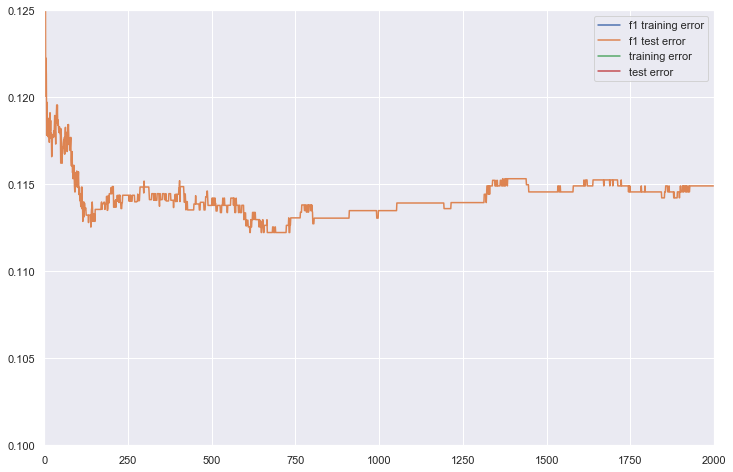

In [332]:
plot_evals(cvresult, min_y=0.1, max_y = 0.125)

In [333]:
n_estimators = np.argmin(cvresult['test-f1_eval-mean'].values)
max_f1 = 1 - min(cvresult['test-f1_eval-mean'])
(n_estimators, f'f1 score is {max_f1}')

(614, 'f1 score is 0.8877686')

In [334]:
params_dict['n_estimators'] = n_estimators

In [335]:
params_dict

{'eta': 0.01,
 'max_depth': 14,
 'gamma': 0.1,
 'subsample': 0.6444444444444444,
 'colsample_bytree': 0.7777777777777778,
 'objective': 'binary:logistic',
 'min_child_weight': 1,
 'scale_pos_weight': 5,
 'alpha': 1e-05,
 'lambda': 1e-05,
 'n_estimators': 614}

In [338]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.set_params(**params_dict)
cv_scores = cross_validate(xgb_clf, X_train_scaled, y_train, scoring=['f1', 'accuracy'], cv=5, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.4s finished


In [339]:
cv_scores

{'fit_time': array([14.1854465 , 14.08147788, 13.82356071, 14.14445972, 14.50334072]),
 'score_time': array([0.28590631, 0.29690647, 0.31690121, 0.28690743, 0.20793319]),
 'test_f1': array([0.90485437, 0.87698413, 0.90019569, 0.89788054, 0.87058824]),
 'test_accuracy': array([0.98289106, 0.97835196, 0.98219274, 0.98148795, 0.97694726])}

In [340]:
cv_scores['test_f1'].mean()

0.8901005930851124

# Naive Bayes

Trying a naive bayes classifier, not expected to do great because 4 first and 4 last features should not be independent given the target value

In [13]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
cv_scores = cross_validate(gnb, X_train_scaled, y_train, scoring=['f1', 'accuracy'])

In [14]:
cv_scores

{'fit_time': array([0.00399852, 0.00299883, 0.0019989 , 0.00399685, 0.00300407]),
 'score_time': array([0.0030117 , 0.0019989 , 0.0029881 , 0.00300002, 0.00199342]),
 'test_f1': array([0.74958541, 0.74188034, 0.73935264, 0.74876847, 0.70382166]),
 'test_accuracy': array([0.94727654, 0.94727654, 0.94657821, 0.94655955, 0.93503318])}